***STEP 1: DATA COLLECTION***

1. Problem statement and data collection

Inspiration
What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?

In [27]:
import pandas as pd

airbnb_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")
airbnb_data.head()



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [28]:
airbnb_data.to_csv("../data/raw/airbnb_data.csv", index = False)

***STEP 2: EXPLORATION AND DATA CLEANING***

In [29]:
# Obtain dimensions
print(airbnb_data.shape)

# Obtain information about data types and non-null values
print(airbnb_data.info())

(48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review         

In [30]:
airbnb_data.isna().sum()[airbnb_data.isna().sum()>0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

##### Statements

* This DataFame is composed by 48 895 rows and 16 columns (variables). 
* The variables "last_review" (10052 nulls) and "reviews_per_month" (10052 nulls) only have 38 843 instances with values, so it would contain more than 10000 null values. The variables "name" (16 nulls)  and "host_name" (21 nulls) also have null values, but in a much smaller number than the previous two. The rest of the variables always have a value. 
* The data has:
    * **10 numerical variables** - id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count and availability_365.
    * **6 categorical variables** - name, host_name, neighbourhood_group, neighbourhood, room_type and last_review.

*****Eliminate duplicates*****

In [31]:
airbnb_data.drop("id", axis =1).duplicated().sum()

np.int64(0)

##### Statement

* To analyze the duplicates, I removed the "id" column, so that this variable, which must be unique, does not "hide" the duplicates in the other columns.
* Any duplicate values were found. 

****Eliminate irrelevant information****

In [32]:
airbnb_data.drop(["id", "name", "host_id", "host_name", "last_review", "reviews_per_month"], axis = 1, inplace = True)
airbnb_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


##### Statement

The algorithm will not use these variables - id, name, host_id host_name, last_review, reviews_per_month - in the predictive process; so can be considered non essential to make a prediction. 

Reasoning behind dropping these variables from the data:

* **id, name, host_id and host_name** - these features are mainly identifiers in our database and can not be influence the frequency of rentals at each location; and as was statement above, the variables "name" and "host_name" have null values.

* **last_review and reviews_per_month** - since we lack additional dates to connect with this feature, we opted to remove it. The relevant information regarding reviews is already represented in our DataFrame by the 'number_of_reviews' column.

***STEP 3: ANALYSIS OF UNIVARIATE VARIABLES***

#### Analysis of categorical variables

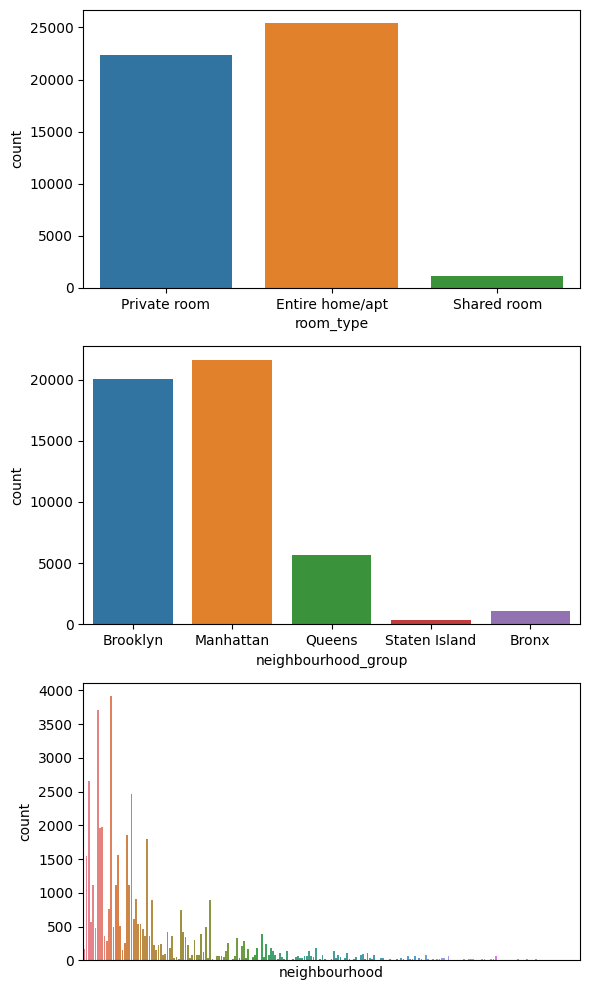

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize = (6, 10))
sns.countplot(ax= ax[0], data = airbnb_data, x = "room_type", hue='room_type')
sns.countplot(ax = ax[1], data = airbnb_data, x = "neighbourhood_group", hue='neighbourhood_group')
sns.countplot(ax = ax[2], data = airbnb_data, x = 'neighbourhood', hue='neighbourhood')
plt.xticks(rotation=90, fontsize=6)

ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels

plt.tight_layout()
plt.show()


#### Statements 
With the representation of each variable by plotting their histogram, it's possible to determine that:

* ****room_type**** - this variable shows that most listings are for Private room and Entire home/apt, which is expected, as this offers more privacy and comfort to guests.

* ****neighbourhood_group**** - this variable shows a unequal distribution. Most properties are concentrated in Brooklyn and Manhattan, reflecting the higher demand and real estate value in these central areas, as well as their tourist and commercial appeal, compared to Staten Island and Bronx.

* ****neighbourhood**** - the distribution suggests that some neighborhoods are much more popular for Airbnb rentals than others. This could be due to tourist appeal, ease of access to public transportation, or simply the number of available listings. The long tail of the distribution suggests that most neighborhoods have few listings, with demand concentrated in a few highly popular neighborhoods.



#### Analysis on numeric variables

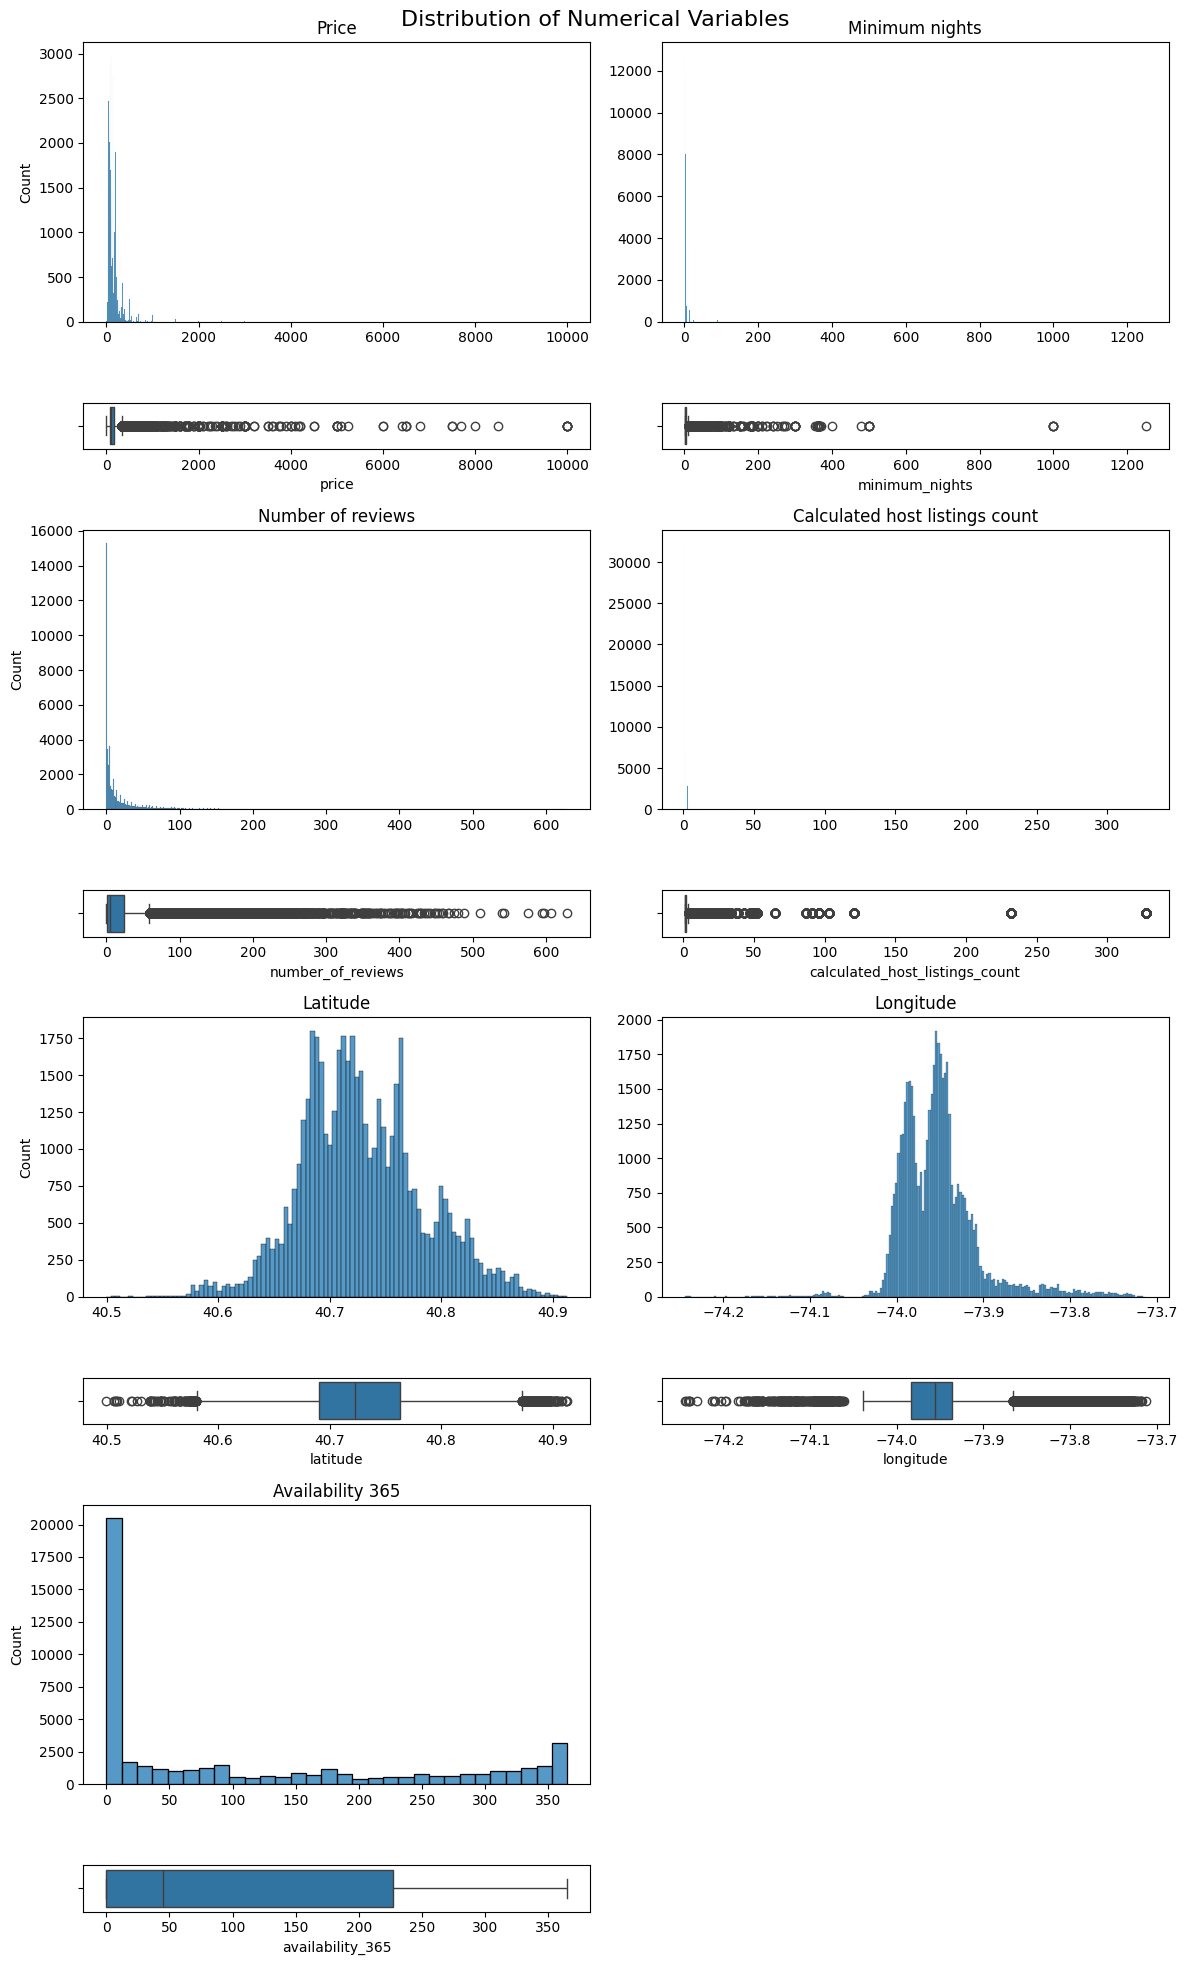

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=airbnb_data, x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=airbnb_data, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=airbnb_data, x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=airbnb_data, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=airbnb_data, x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=airbnb_data, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=airbnb_data, x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=airbnb_data, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=airbnb_data, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=airbnb_data, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=airbnb_data, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=airbnb_data, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=airbnb_data, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=airbnb_data, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[7, 1])
fig.delaxes(axis[6, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


* to have a better visualization of the data distribution, I decide to graph a new version without outliers:

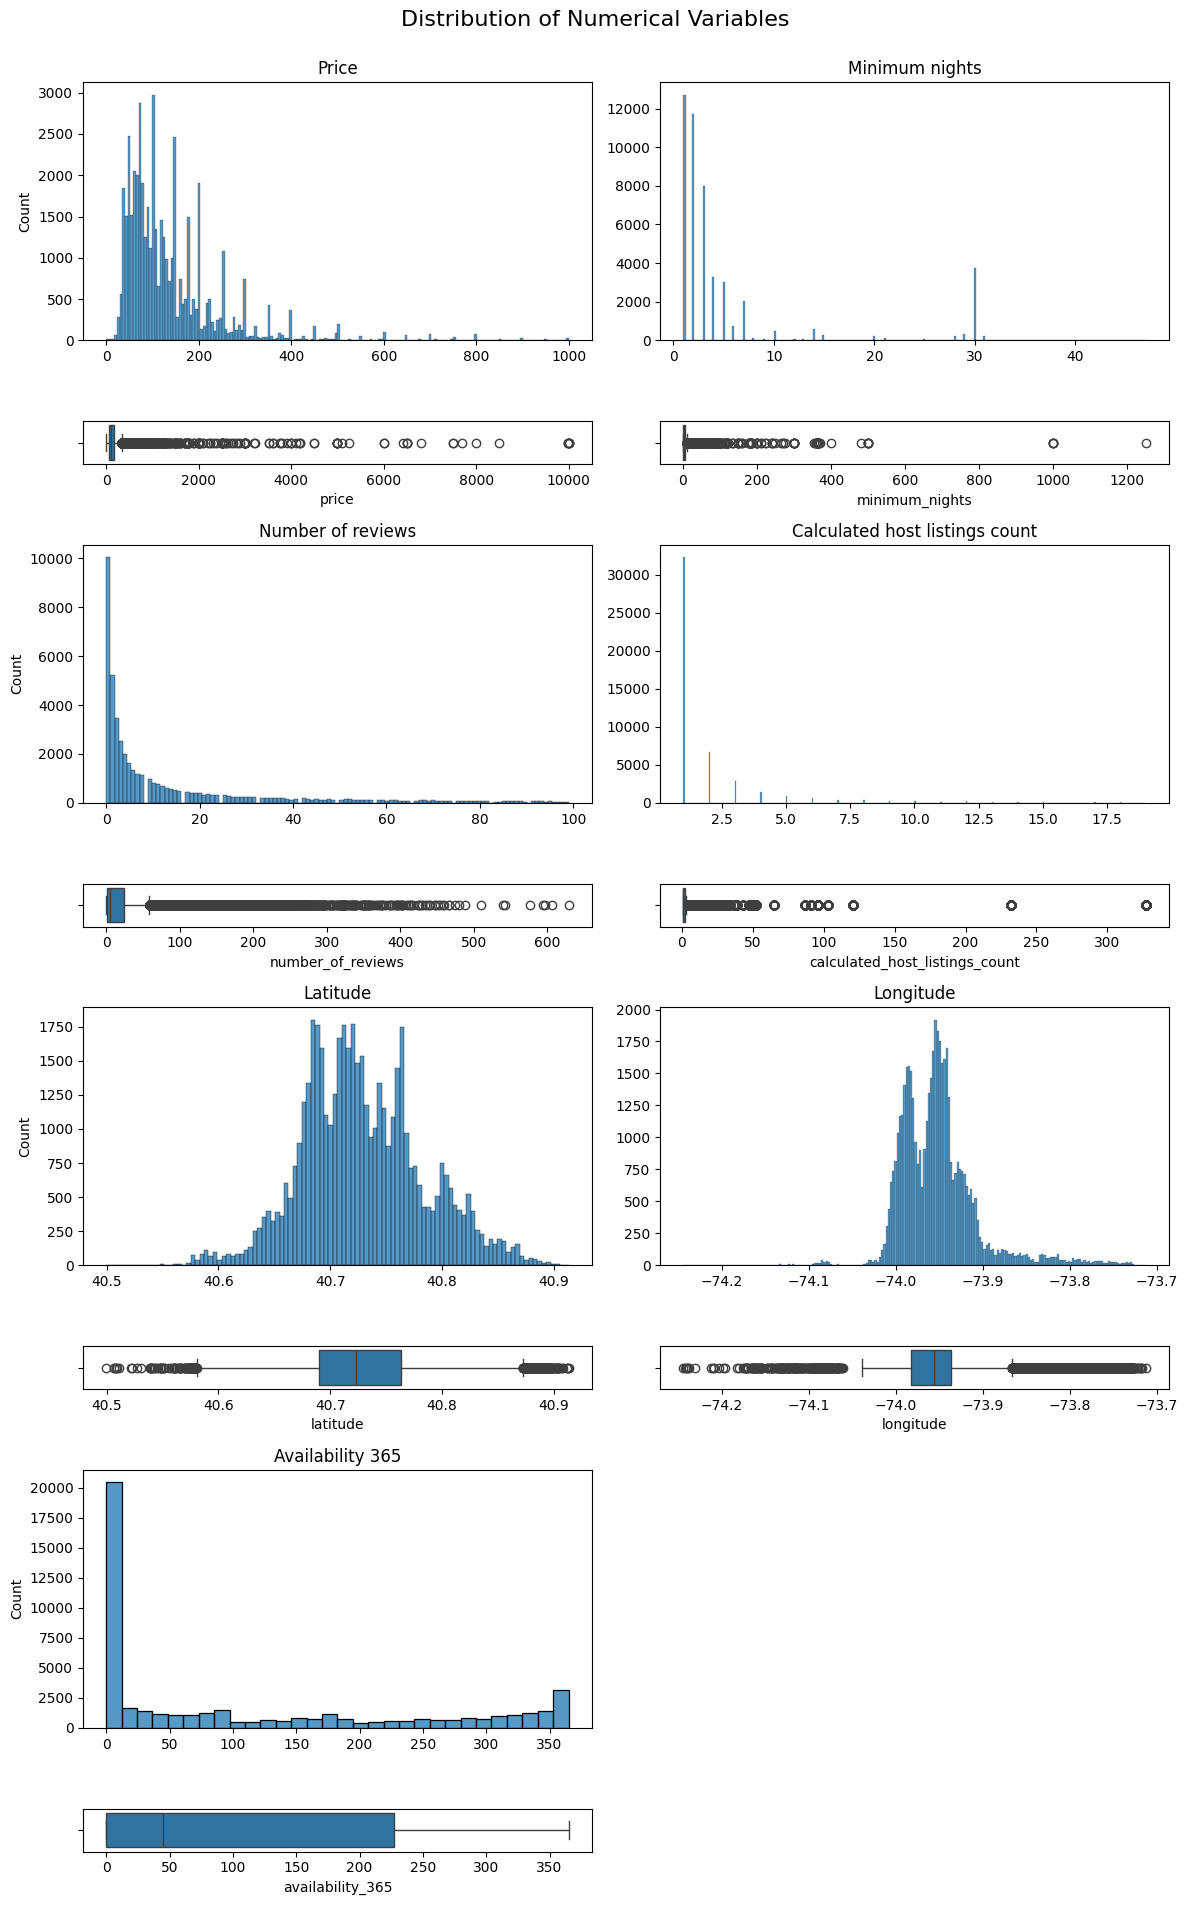

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=airbnb_data[airbnb_data["price"] < 1000], x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=airbnb_data, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=airbnb_data[airbnb_data["minimum_nights"] < 50], x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=airbnb_data, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=airbnb_data[airbnb_data["number_of_reviews"] < 100], x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=airbnb_data, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=airbnb_data[airbnb_data["calculated_host_listings_count"] < 20], x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=airbnb_data, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=airbnb_data, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=airbnb_data, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=airbnb_data, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=airbnb_data, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=airbnb_data, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=airbnb_data, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[6, 1])
fig.delaxes(axis[7, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the plot
plt.show()


#### Statements

 
* **Price:** this variable is central to modeling rental cost and helps identify luxury or economy listings; most listings are concentrated in lower price ranges, while only a few properties charge very high rates. This may indicate that the Airbnb market in New York is accessible for different budgets, though with some luxury or exclusive properties.

* **Minimum Nights:** this variable helps differentiate between posts geared towards short and long stays; the distribution shows that most hosts do not require a very high minimum number of nights.

* **Number of Reviews:** this variable indicates the popularity and frequency of use of properties; most listings have few reviews, suggesting that many properties may be new or have low popularity. However, listings with many reviews may indicate high-demand properties.

* **Calculated Host Listings Count:** this variable reflects the level of experience or professionalism of hosts, differentiating casual hosts from multi-property managers; most hosts have only one or a few properties, indicating that the Airbnb market in New York is largely dominated by small hosts. However, there are a few large hosts with many listings, suggesting the presence of professionals in the market.

* **Latitude and longitude:** geographic location tends to be one of the main factors influencing price and demand, especially in large cities. Properties in central areas or near tourist attractions tend to be more expensive. The histogram shows that most Airbnb listings in New York are in central or popular areas. This analysis suggests that this variable may be important in predicting price and popularity, as listings closer to the center or high-demand areas are likely to be more valuable.

* **Availability_365:** the bimodal distribution of availability suggests that most properties have low availability, pointing to occasional rentals, while a smaller subset remains open year-round, likely managed by professional hosts. So, this indicates a mix of dedicated hosts and potentially seasonal or inactive listings.

***STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES***

#### Numerical-numerical analysis

Since we are faced with an Airbnb dataset, the variable of interest for this bivariate analysis could be **price**, as it is a ***continuous numerical*** variable that is ***central*** to the context of accommodation. Analyzing how price varies in relation to other variables can help us understand which factors most influence rental prices.

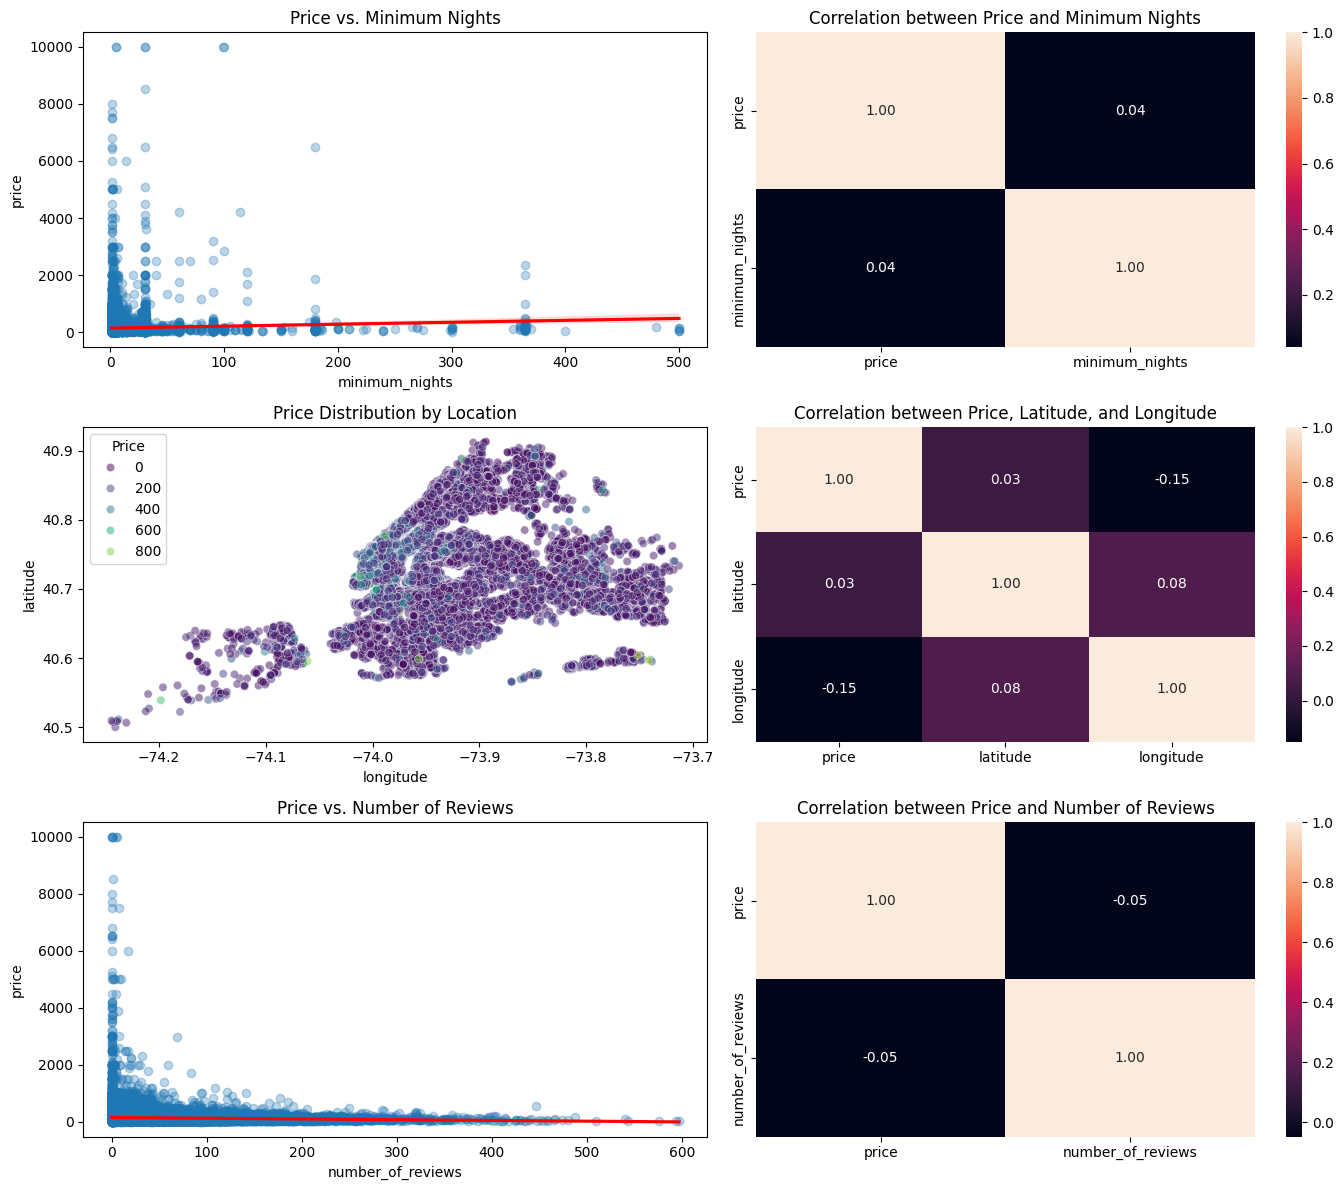

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14, 12))

# 1. Scatter plot: Price vs. Minimum Nights with regression line
plt.subplot(3, 2, 1)
sns.regplot(data=airbnb_data[airbnb_data["minimum_nights"] < 600], x='minimum_nights', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Minimum Nights')

#2. Correlation Heatmap for Price and Minimum Nights
plt.subplot(3, 2, 2)
corr_min_nights_price = airbnb_data[['price', 'minimum_nights']].corr()
sns.heatmap(corr_min_nights_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Minimum Nights')

# 3. Scatter plot: Price vs. Location (Latitude and Longitude)
plt.subplot(3, 2, 3)
sns.scatterplot(data=airbnb_data[airbnb_data["price"] < 1000], x='longitude', y='latitude', hue='price', palette='viridis', alpha=0.5)
plt.title('Price Distribution by Location')
plt.legend(title='Price')

# 4. Correlation Heatmap for Latitude and Longitude
plt.subplot(3, 2, 4)
corr_lat_long_price = airbnb_data[['price', 'latitude', 'longitude']].corr()
sns.heatmap(corr_lat_long_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price, Latitude, and Longitude')

# 5. Scatter plot: Price vs. Number of Reviews with regression line
plt.subplot(3, 2, 5)
sns.regplot(data=airbnb_data[airbnb_data["number_of_reviews"] < 600], x='number_of_reviews', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Number of Reviews')

# 6. Correlation Heatmap for Price and Number of Reviews
plt.subplot(3, 2, 6)
corr_reviews_price = airbnb_data[['price', 'number_of_reviews']].corr()
sns.heatmap(corr_reviews_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Number of Reviews')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Statements

**Price - Minimum Nights:**  
* most lower priced listings (around 2,000 and under) have a minimum number of nights ranging from 1 to 50.
* for minimum_nights values ​​above 100, prices tend to be lower, suggesting that listings with longer minimum stays offer reduced rates, possibly to attract longer stays.
* there is no relation between the **price** and **minimum nights**.

**Price Distribution by Location (Latitude vs. Longitude):** 
* the areas with the highest prices seem to be concentrated in the central region (where lighter colored dots represent higher values).
* the southernmost and most remote areas tend to have lower prices, which is common in cities where the urban center is valued.
* the geographic distribution confirms that location has a direct impact on prices, with central areas, close to points of interest, charging significantly higher prices.
* there is a slight negative correlation between **price** and **longitude**, suggesting that areas further west (closer to Manhattan) may have slightly higher prices. However, this ***correlation is very weak*** (-0.15).

**Price vs. Number of Reviews:** 
* most listings with a high number of reviews (over 100) are relatively low-priced, suggesting that more popular listings are those with more affordable rates.
* this distribution suggests an inverse relationship between price and number of reviews, indicating that lower-priced properties may be more popular or affordable, thus accumulating more reviews.
* there is no relation between the **price** and the **number of reviews**.

#### Categorical-Categorical analysis

* **Categorical variables in analysis:** 

    * room_type
    * neighbourhood
    * neighbourhood_group

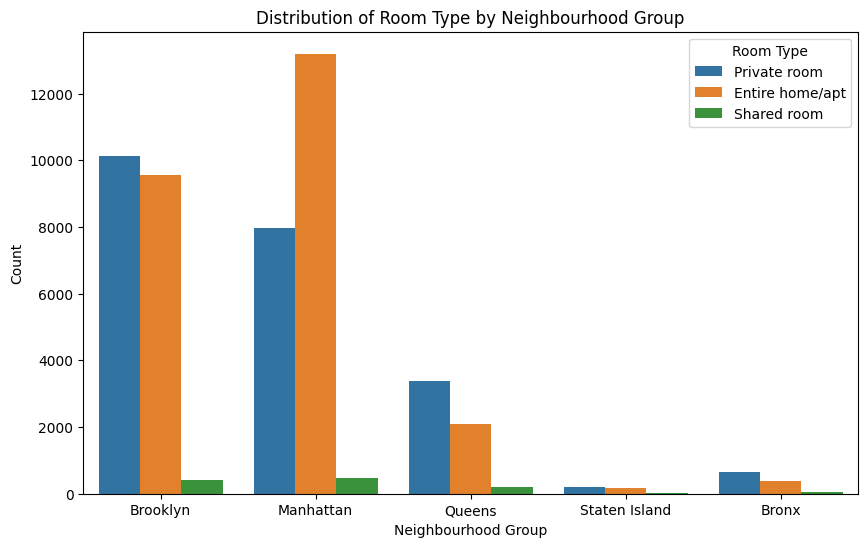

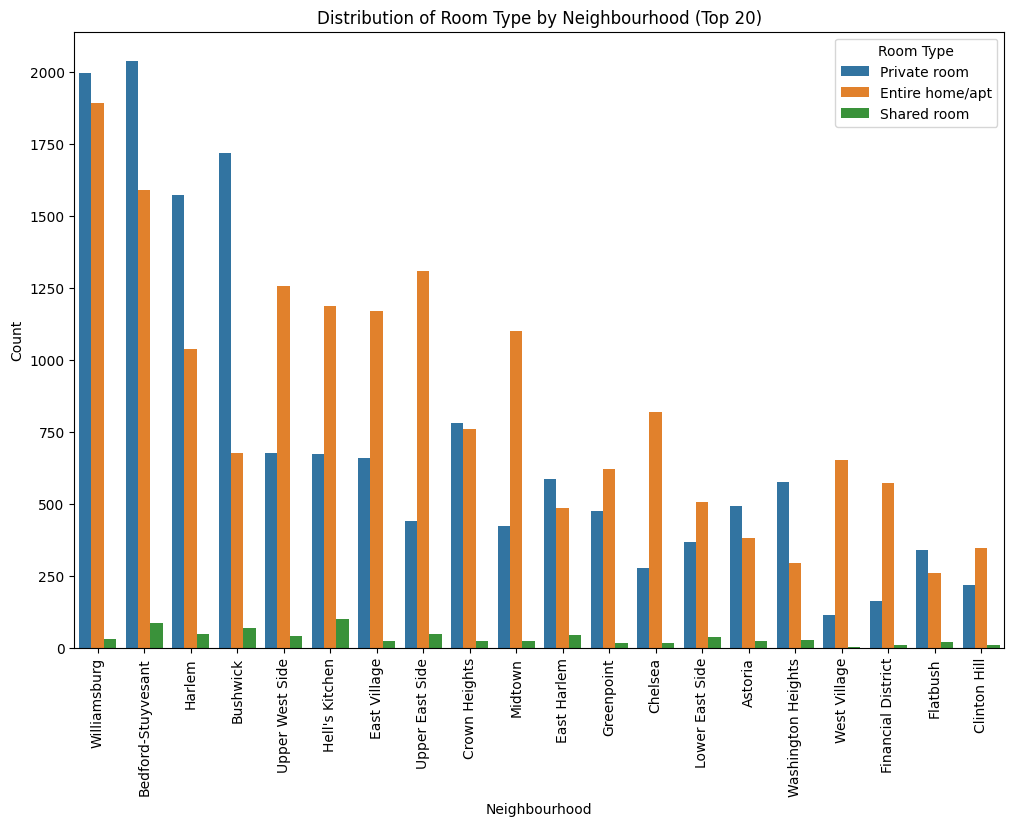

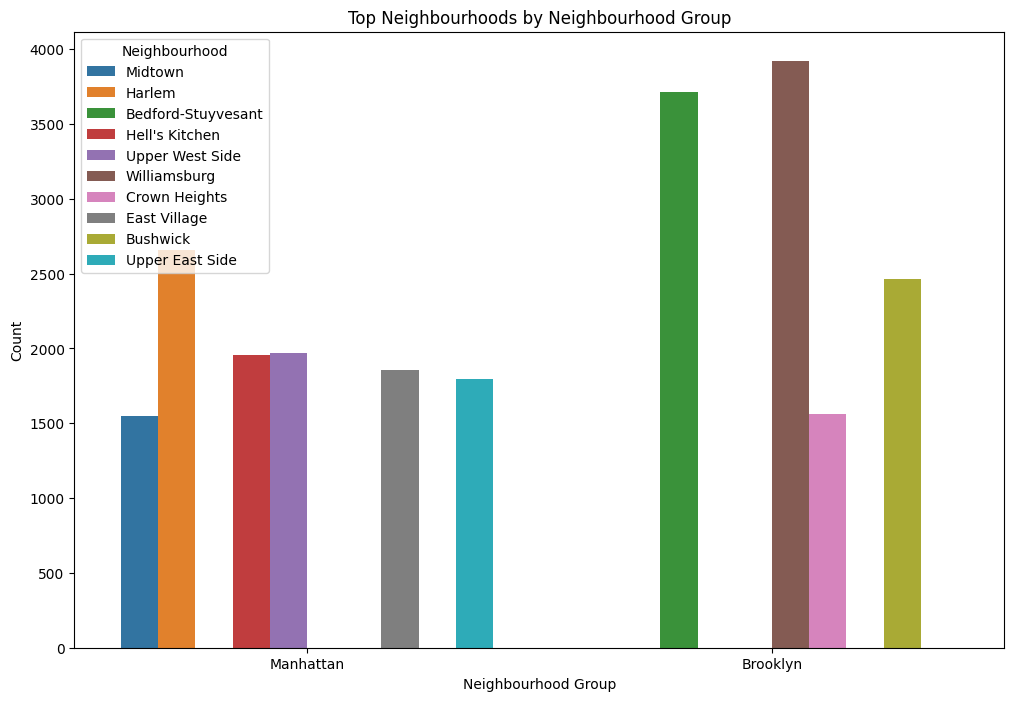

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Countplot: Neighbourhood Group vs. Room Type
plt.figure(figsize=(10, 6))
sns.countplot(data=airbnb_data, x='neighbourhood_group', hue='room_type')
plt.title('Distribution of Room Type by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Room Type')
plt.show()

# 2. Countplot: Neighbourhood vs. Room Type (focusing on individual neighbourhoods)
plt.figure(figsize=(12, 8))
sns.countplot(data=airbnb_data, x='neighbourhood', hue='room_type', order=airbnb_data['neighbourhood'].value_counts().index[:20])
plt.title('Distribution of Room Type by Neighbourhood (Top 20)')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(title='Room Type')
plt.show()

# 3. Countplot: Neighbourhood Group vs. Neighbourhood (top 10 neighbourhoods per group)
# Limiting to the top neighbourhoods in each group for clarity
top_neighbourhoods = airbnb_data['neighbourhood'].value_counts().index[:10]
filtered_data = airbnb_data[airbnb_data['neighbourhood'].isin(top_neighbourhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_data, x='neighbourhood_group', hue='neighbourhood')
plt.title('Top Neighbourhoods by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Neighbourhood', loc='upper left')
plt.show()



#### Statements

* Room Type Distribution: Entire home/apt is more common in tourist areas (especially Manhattan), while Private room is more prevalent in residential neighborhoods in Brooklyn.
* Rarity of Shared room: This type of accommodation is less common in all neighborhoods, suggesting a decrease in interest in shared stays.
* High Demand in Popular Areas: Neighborhoods such as Midtown and Williamsburg have a significant concentration of listings, reflecting their popularity and potential for short-term rentals.


#### From string to numerical transformation -> json saving

In [38]:
import pandas as pd
import json

# Function to perform the transformation using pd.factorize and save the mapping
def factorize_and_save(df, column_name, json_filename):
    # Factorize a coluna
    factorized_values, unique_values = pd.factorize(df[column_name])

    # Create the mapping dictionary
    mapping_dict = {unique_values[i]: int(factorized_values[i]) for i in range(len(unique_values))}

    # Save the mapping to a JSON file
    with open(json_filename, "w") as f:
        json.dump(mapping_dict, f)

    # Add the transformed column to the DataFrame
    df[column_name + "_n"] = factorized_values

# Apply the function to the categorical columns we want to transform
factorize_and_save(airbnb_data, "room_type", "transform_room_type.json")
factorize_and_save(airbnb_data, "neighbourhood", "transform_neighbourhood.json")
factorize_and_save(airbnb_data, "neighbourhood_group", "transform_neighbourhood_group.json")

In [39]:
# Create a new DataFrame and remove the original categorical columns
airbnb_data_n = airbnb_data.drop(columns=["room_type", "neighbourhood", "neighbourhood_group"]).copy()

# Display the first few rows of the final DataFrame to check
print(airbnb_data_n.head())


   latitude  longitude  price  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237    149               1                  9   
1  40.75362  -73.98377    225               1                 45   
2  40.80902  -73.94190    150               3                  0   
3  40.68514  -73.95976     89               1                270   
4  40.79851  -73.94399     80              10                  9   

   calculated_host_listings_count  availability_365  room_type_n  \
0                               6               365            0   
1                               2               355            1   
2                               1               365            0   
3                               1               194            1   
4                               1                 0            1   

   neighbourhood_n  neighbourhood_group_n  
0                0                      0  
1                1                      1  
2                2                      1  
3     

#### CORRELATION MATRIX

#### Numerical-Categorical analysis (complete)

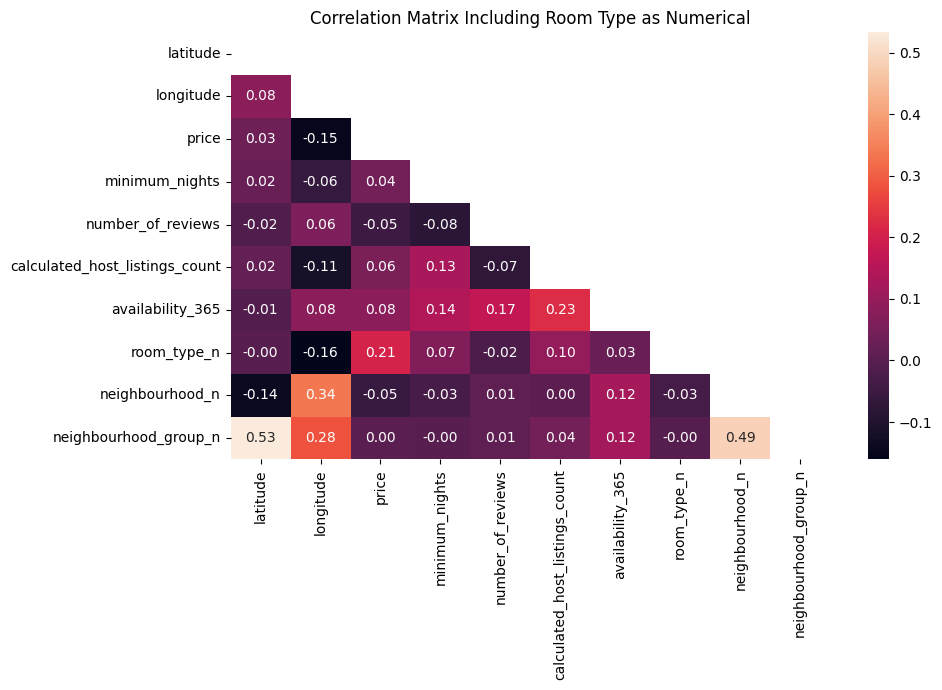

In [40]:
import numpy as np

plt.figure(figsize=(10, 7))

sns.heatmap(airbnb_data_n.corr(), annot=True, fmt=".2f", mask= np.triu(airbnb_data_n.corr()))
plt.title("Correlation Matrix Including Room Type as Numerical")

plt.tight_layout()
plt.show()



1. **Price and Room Type**:
   - There’s a positive correlation of 0.21 between `price` and `room_type_n`, indicating that different accommodation types influence price. This suggests that entire homes tend to be more expensive than private or shared rooms.

2. **Calculated Host Listings Count and Availability**:
   - `calculated_host_listings_count` and `availability_365` have a positive correlation of 0.23, suggesting that hosts with multiple listings tend to keep properties available for more days per year, indicating a higher presence of professional hosts.

3. **Neighbourhood Group and Neighbourhood**:
   - `neighbourhood_group_n` and `neighbourhood_n` show a strong positive correlation of 0.49, which is expected, as specific neighborhoods are grouped within larger neighborhood regions. This correlation reflects the dataset’s geographic structure.

4. **Minimum Nights and Availability**:
   - The correlation of 0.14 between `minimum_nights` and `availability_365` is weak, suggesting that, in some areas, higher minimum night requirements may be slightly associated with greater availability.

5. **Reviews and Availability**:
   - A correlation of 0.17 between `number_of_reviews` and `availability_365` suggests that listings available for more days tend to receive more reviews, likely due to more booking opportunities.

6. **Weak Correlation with Price**:
   - `price` shows low correlations with most other variables, except for a slight correlation with `room_type_n` (0.21). This suggests that price may be influenced by other property characteristics not represented in this dataset.

7. **Other Weak Correlations**:
   - Most other variables show very weak or near-zero correlations with each other, indicating low interdependence between categorical and numerical variables in the dataset.



#### Analysing all the variables

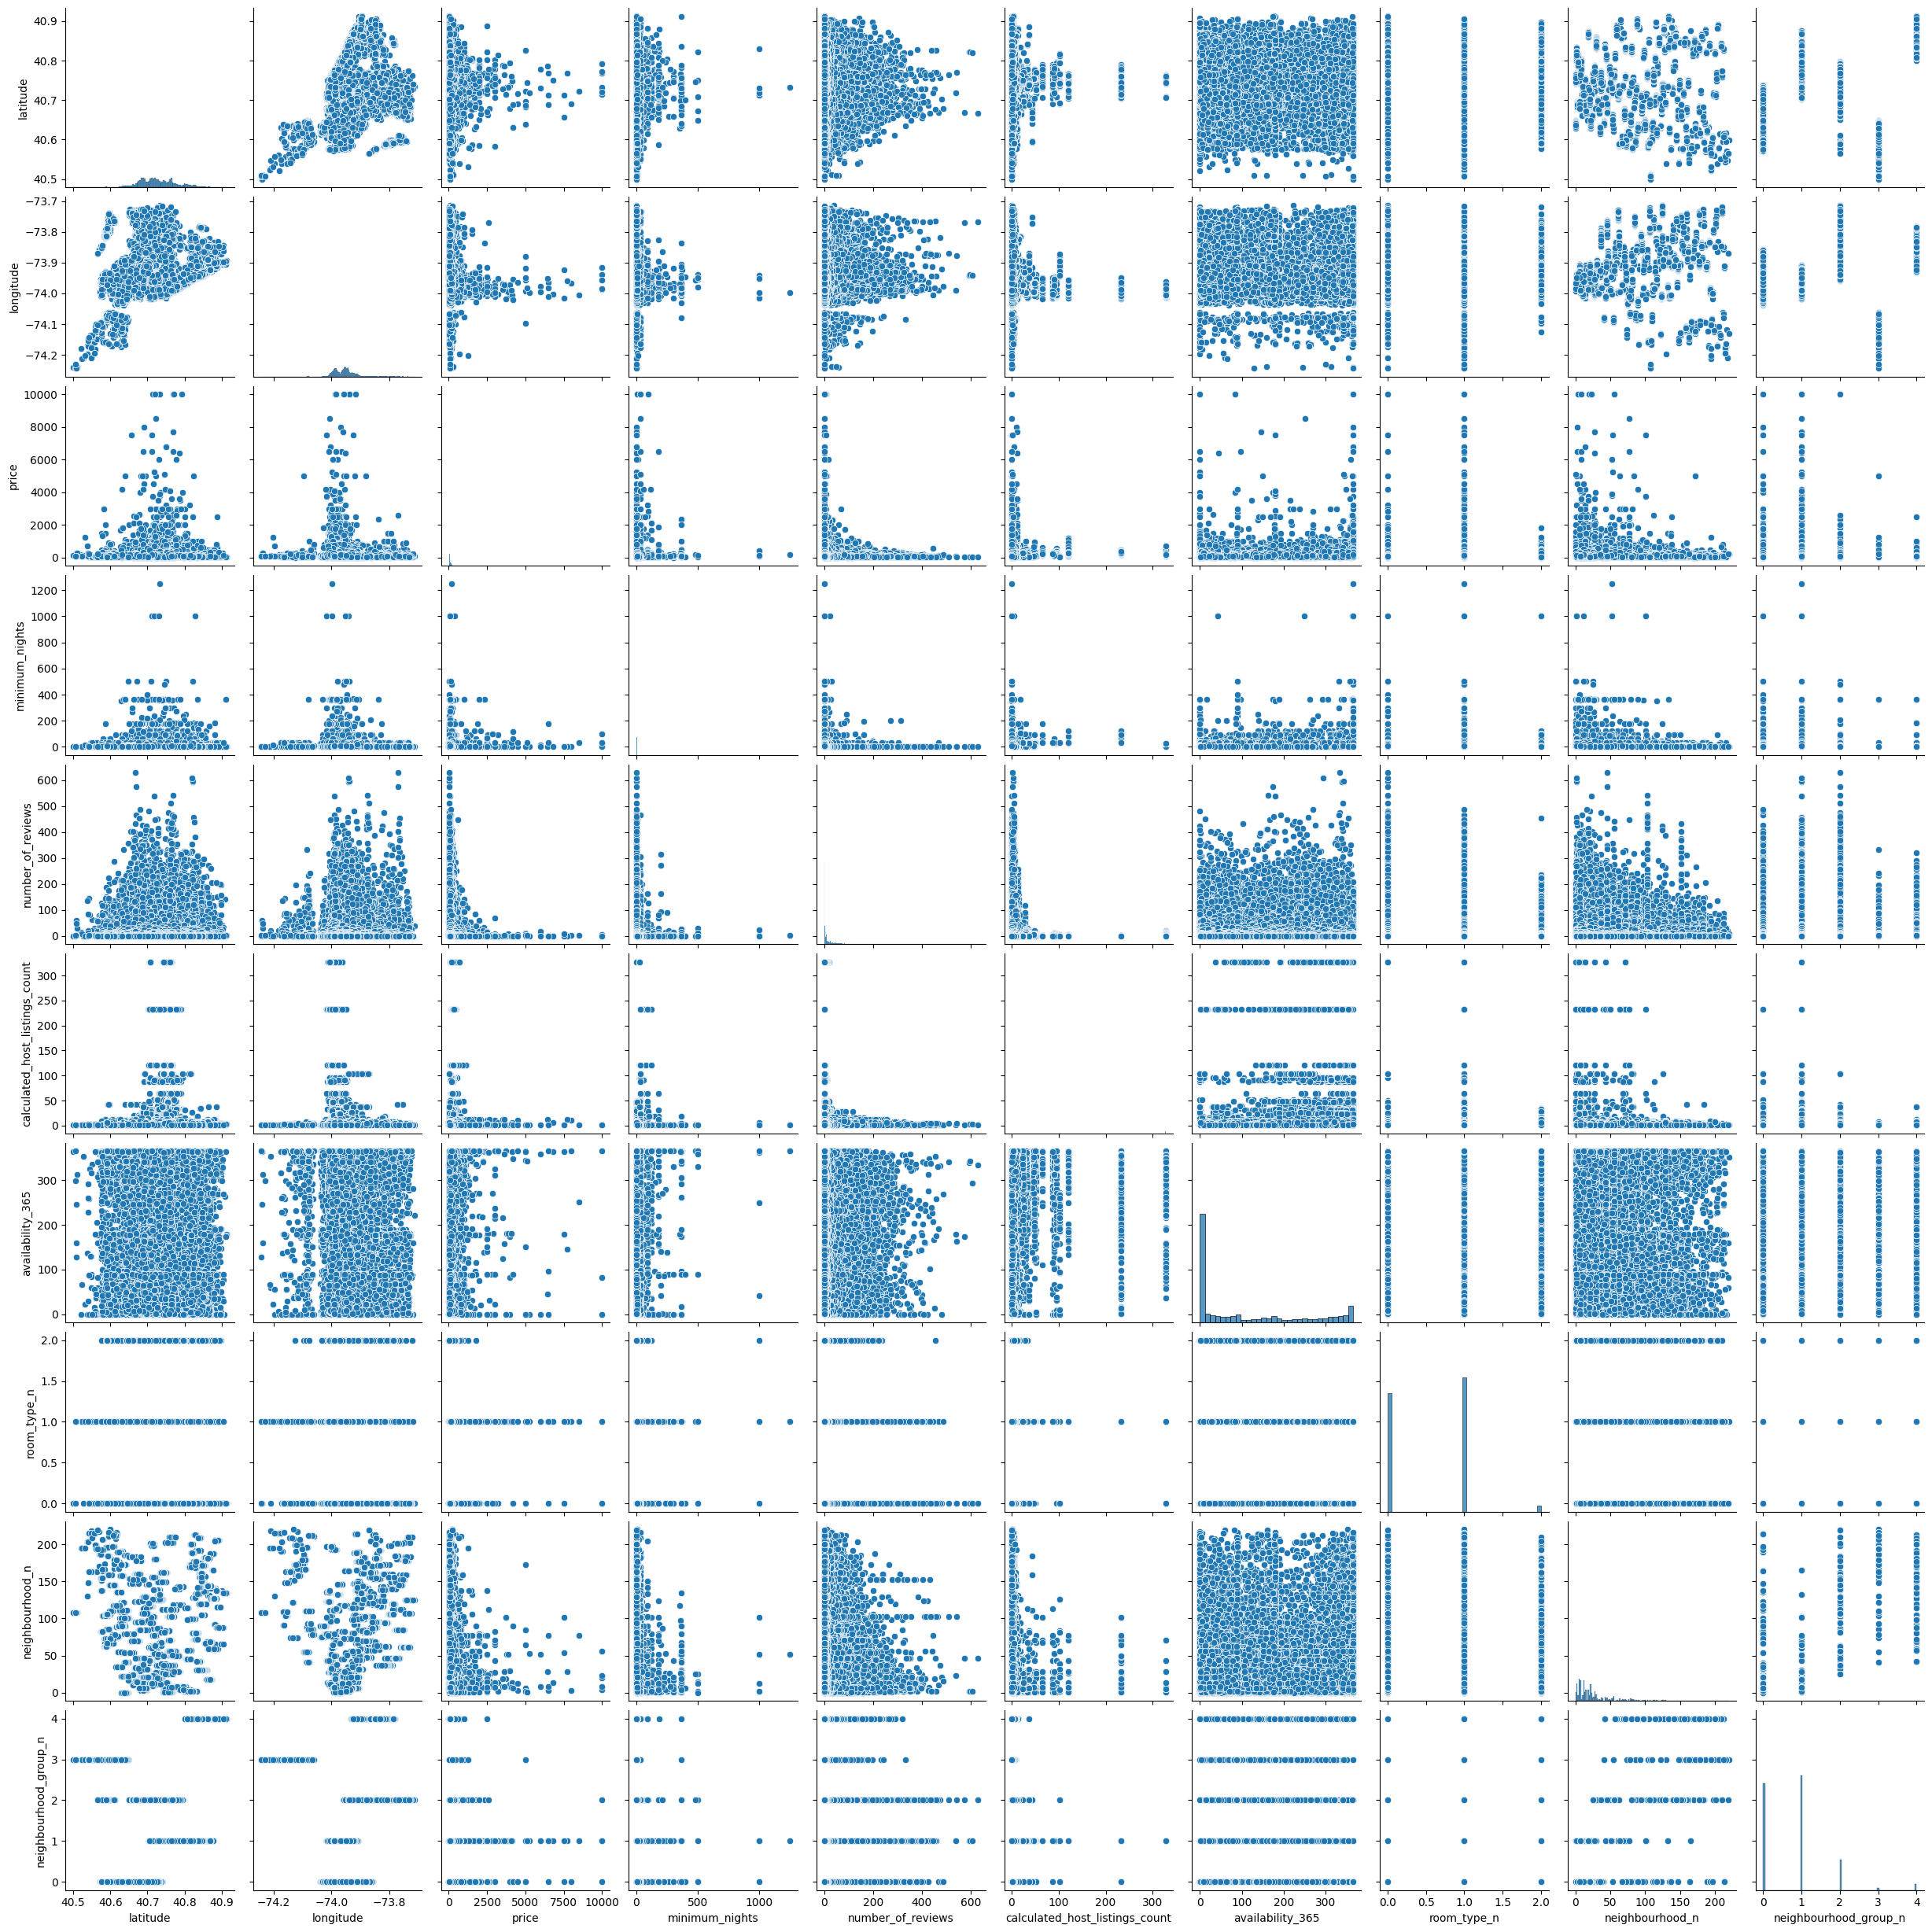

In [41]:
sns.pairplot(data = airbnb_data_n)

***STEP 5: FEATURE ENGINEERING***

In [42]:
airbnb_stats = airbnb_data_n.describe()
airbnb_stats

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_n,neighbourhood_group_n
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327,0.567113,29.888782,0.786911
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289,0.541249,34.676634,0.844386
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.500000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000,1.000000,19.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000,1.000000,37.000000,1.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000,2.000000,220.000000,4.000000


Based on the descriptive statistics, it is possible to observe that:
* **mean-** The mean is affected by extremely high values ​​in all variables, suggesting that the data has many outliers;

* **Standard deviation-** The high variability confirms the presence of outliers, since the standard deviation is very high in relation to the means and central values, which suggests that the data is quite dispersed;

* **min-** The minimum values ​​seem reasonable and reflect the typical behavior of listings with minimum stay requirements and of varying popularity;

* **25%, 50% and 75%-** The quartiles indicate a very uneven distribution, especially in the minimum_nights and calculated_host_listings_count variables, with a large number of values ​​close to the upper limits, probably from large property managers or accommodations with exceptional requirements;

* **max-** The maximum values ​​are unrealistically high, which confirms the presence of extreme outliers that distort the overall metrics.

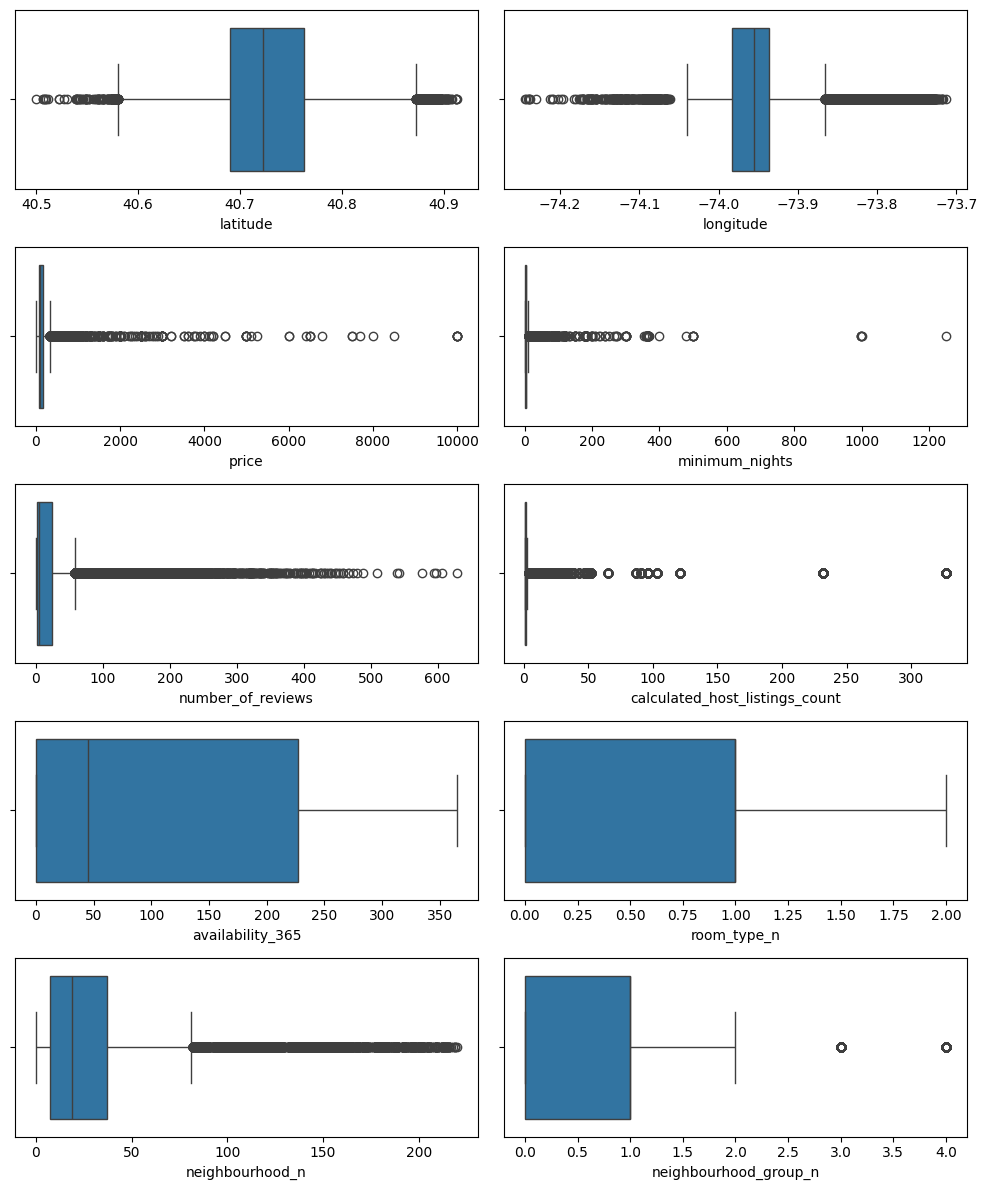

In [43]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

sns.boxplot(ax = ax[0,0], data = airbnb_data_n, x='latitude')
sns.boxplot(ax = ax[0,1], data = airbnb_data_n, x='longitude')

sns.boxplot(ax = ax[1,0], data = airbnb_data_n, x='price')
sns.boxplot(ax = ax[1,1], data = airbnb_data_n, x='minimum_nights')

sns.boxplot(ax = ax[2,0], data = airbnb_data_n, x='number_of_reviews')
sns.boxplot(ax = ax[2,1], data = airbnb_data_n, x='calculated_host_listings_count')

sns.boxplot(ax = ax[3,0], data = airbnb_data_n, x='availability_365')
sns.boxplot(ax = ax[3,1], data = airbnb_data_n, x='room_type_n')

sns.boxplot(ax = ax[4,0], data = airbnb_data_n, x='neighbourhood_n')
sns.boxplot(ax = ax[4,1], data = airbnb_data_n, x='neighbourhood_group_n')

plt.tight_layout()
plt.show()

The following variables are essential for outlier treatment, as they are important for understanding price behavior, listing popularity, and host profiles:
* **minimum_nights** - To better reflect the reality of most stays without excessive requirements.
* **number_of_reviews** - To ensure that highly popular listings do not distort demand analyses.
* **calculated_host_listings_count** - To distinguish between casual hosts and large property managers.

### Outlier Analysis

In [47]:
df_with_outliers = airbnb_data_n.copy()
df_without_outliers = airbnb_data_n.copy()

In [51]:
import os
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*2)
    lower_lim = q1 - (iqr*2) if allow_neg else max(0, q1 - (iqr * 2))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))
    # create a directory 
    os.makedirs('./enc', exist_ok=True)

    # Save the limits to a JSON file
    filename = f'./enc/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [52]:
df_without_outliers['minimum_nights'] = remove_outliers(df_without_outliers['minimum_nights'], 'minimum_nights')
df_without_outliers['number_of_reviews'] = remove_outliers(df_without_outliers['number_of_reviews'], 'number_of_reviews')
df_without_outliers['calculated_host_listings_count'] = remove_outliers(df_without_outliers['calculated_host_listings_count'], 'calculated_host_listings_count')


### Missing Values

In [54]:
df_with_outliers.isnull().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
room_type_n                       0
neighbourhood_n                   0
neighbourhood_group_n             0
dtype: int64

#### Statement
As we can see, there are no missing values.

### New feature inference


In the context of Exploratory Data Analysis (EDA) for lodging data, creating new variables can be particularly relevant to understanding patterns of behavior, profitability, and popularity. Here are the ones I consider most important:

* **Occupancy rate-** to understand which listings are in highest demand. Since the number of reviews can be an indirect indication of booking frequency, occupancy_rate helps identify listings that are most popular and frequently occupied throughout the year.

* **Revenue estimate-** allows you to get an idea of ​​the financial potential of each listing. In a market analysis context, this variable can help identify the most profitable areas and types of accommodation.

Creating the new variables in both DataFrames (df_with_outliers and df_without_outliers). This way, each DataFrame will have the derived variables, and you can compare the results with and without the outliers.

In [56]:
# Creating "Occupancy rate" variable
df_with_outliers['occupancy_rate'] = (df_with_outliers['number_of_reviews'] / df_with_outliers['availability_365']) * 100
df_without_outliers['occupancy_rate'] = (df_without_outliers['number_of_reviews'] / df_without_outliers['availability_365']) * 100

# Creating "Estimated revenue" variable
df_with_outliers['estimated_revenue'] = df_with_outliers['price'] * df_with_outliers['availability_365']
df_without_outliers['estimated_revenue'] = df_without_outliers['price'] * df_without_outliers['availability_365']


In [57]:
df_with_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_n,neighbourhood_group_n,occupancy_rate,estimated_revenue
0,40.64749,-73.97237,149,1,9,6,365,0,0,0,2.465753,54385
1,40.75362,-73.98377,225,1,45,2,355,1,1,1,12.676056,79875
2,40.80902,-73.94190,150,3,0,1,365,0,2,1,0.000000,54750
3,40.68514,-73.95976,89,1,270,1,194,1,3,0,139.175258,17266
4,40.79851,-73.94399,80,10,9,1,0,1,4,1,inf,0


In [58]:
df_without_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_n,neighbourhood_group_n,occupancy_rate,estimated_revenue
0,40.64749,-73.97237,149,1.0,9.0,4.0,365,0,0,0,2.465753,54385
1,40.75362,-73.98377,225,1.0,45.0,2.0,355,1,1,1,12.676056,79875
2,40.80902,-73.94190,150,3.0,0.0,1.0,365,0,2,1,0.000000,54750
3,40.68514,-73.95976,89,1.0,70.0,1.0,194,1,3,0,36.082474,17266
4,40.79851,-73.94399,80,10.0,9.0,1.0,0,1,4,1,inf,0


### Split train/test of both Data Frames

In [64]:
from sklearn.model_selection import train_test_split

# Função para dividir os dados em treino e teste
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)  # Features
    y = df[target]  # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Exemplo com DataFrames com e sem outliers
X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, y_test_with_outliers = split('price', df_with_outliers)
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = split('price', df_without_outliers)

# Salvando os conjuntos de treino e teste
y_train_with_outliers.to_csv('/workspaces/RitaViegas---machine-learning-python-template/data/processed/y_train_with_outliers.csv', index= False)
y_test_with_outliers.to_csv('/workspaces/RitaViegas---machine-learning-python-template/data/processed/y_test_with_outliers.csv', index= False)
y_train_without_outliers.to_csv('/workspaces/RitaViegas---machine-learning-python-template/data/processed/y_train_without_outliers.csv', index= False)
y_test_without_outliers.to_csv('/workspaces/RitaViegas---machine-learning-python-template/data/processed/y_test_without_outliers.csv', index= False)



### Normalization